# Library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px
import autokeras as ak
from sklearn.metrics import mean_absolute_percentage_error
import optuna
#from auto_ts import auto_timeseries

# Data

Github : https://github.com/twairball/gams-dataset

Gams website : www.measureofquality.com

In [14]:
data = pd.read_csv('gams_indoor.csv')

In [15]:
data.head()

,ts,co2,humidity,pm10,pm25,temperature,voc
0,2016-11-21 00:47:03,708.0,72.09,10.2,9.0,20.83,0.062
1,2016-11-21 00:48:03,694.0,70.95,10.9,10.1,21.01,0.062
2,2016-11-21 00:49:03,693.0,69.12,10.2,9.9,21.20,0.062
3,2016-11-21 00:50:03,692.0,68.83,9.6,9.6,21.37,0.062
4,2016-11-21 00:51:03,690.0,68.60,9.4,8.4,21.49,0.062


In [16]:
data['ts'] = pd.to_datetime(data['ts'])

data = data.resample('H', on='ts').mean()

In [17]:
data = data.dropna()

In [18]:
data['hour'] = data.index.hour

In [19]:
data.head(10)

,co2,humidity,pm10,pm25,temperature,voc,hour
ts,,,,,,,
2016-11-21 00:00:00,693.846154,68.351538,8.515385,7.900000,21.731538,0.062000,0
2016-11-21 01:00:00,760.377778,61.866000,5.777778,5.151111,24.032889,0.062889,1
2016-11-21 02:00:00,1174.200000,59.996400,14.792000,12.840000,25.877200,0.063200,2
2016-11-21 03:00:00,1397.740741,59.742963,20.703704,18.666667,26.562963,0.066222,3
2016-11-21 04:00:00,1413.727273,58.885455,12.222727,11.272727,26.835909,0.062773,4
2016-11-21 05:00:00,1521.052632,59.087895,10.347368,9.600000,26.940526,0.062895,5
2016-11-21 06:00:00,1715.160000,59.182800,10.884000,10.112000,27.158800,0.064800,6
2016-11-21 07:00:00,2053.666667,59.427333,7.280000,6.673333,27.452333,0.089233,7
2016-11-21 08:00:00,2416.909091,58.704545,4.604545,4.009091,27.525909,0.077364,8


In [9]:
data.to_csv('1h_data.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2998 entries, 2016-11-21 00:00:00 to 2017-03-28 09:00:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   co2          2998 non-null   float64
 1   humidity     2998 non-null   float64
 2   pm10         2998 non-null   float64
 3   pm25         2998 non-null   float64
 4   temperature  2998 non-null   float64
 5   voc          2998 non-null   float64
dtypes: float64(6)
memory usage: 164.0 KB


<AxesSubplot:>

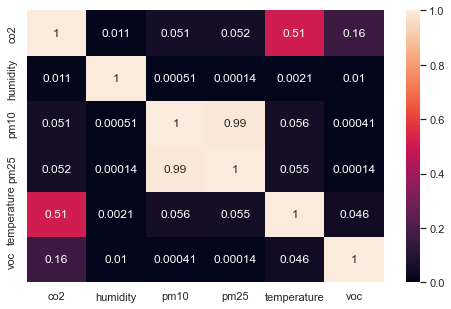

In [32]:
sns.set(rc={'figure.figsize':(8,5)})
corr = data.corr()**2
sns.heatmap(corr, vmin=0, vmax=1, annot=True)

PM10 and PM2.5 have strong correlation. For prediction, it will be better to drop one of the columns to reduce the dimensions.

# Feature Analysis

### CO2

In [103]:
data['co2'].describe()

count    2998.000000
mean      716.030509
std       406.052921
min       372.633333
25%       432.470370
50%       496.273984
75%       914.150000
max      2570.409091
Name: co2, dtype: float64

[Text(0.5, 1.0, 'CO2 levels observations')]

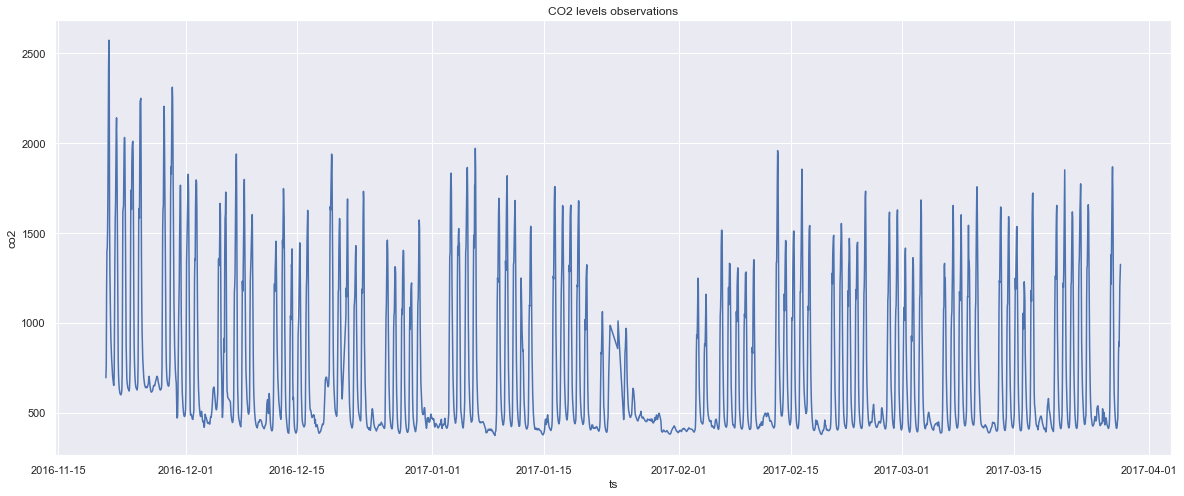

In [105]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot(data=data['co2']).set(title='CO2 levels observations')

### humidity

In [106]:
data['humidity'].describe()

count    2998.000000
mean       38.422101
std         5.499795
min        22.140000
25%        34.702232
50%        38.312860
75%        42.058542
max        68.351538
Name: humidity, dtype: float64

[Text(0.5, 1.0, 'Humidity levels observations')]

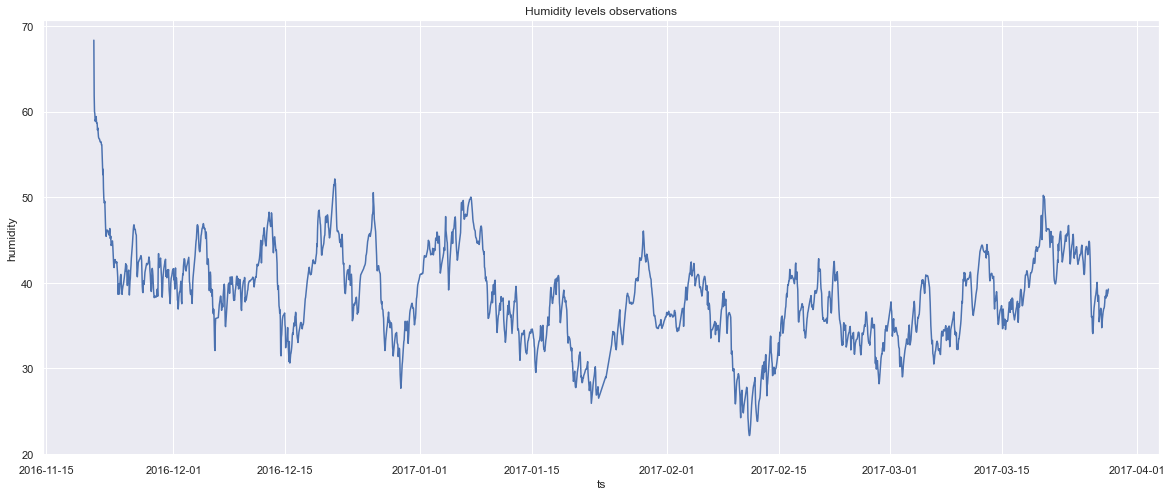

In [108]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot(data=data['humidity']).set(title='Humidity levels observations')

### PM10

In [109]:
data['pm10'].describe()

count    2998.000000
mean       17.378770
std        12.788680
min         0.833333
25%         8.026016
50%        13.533333
75%        23.141944
max        84.356250
Name: pm10, dtype: float64

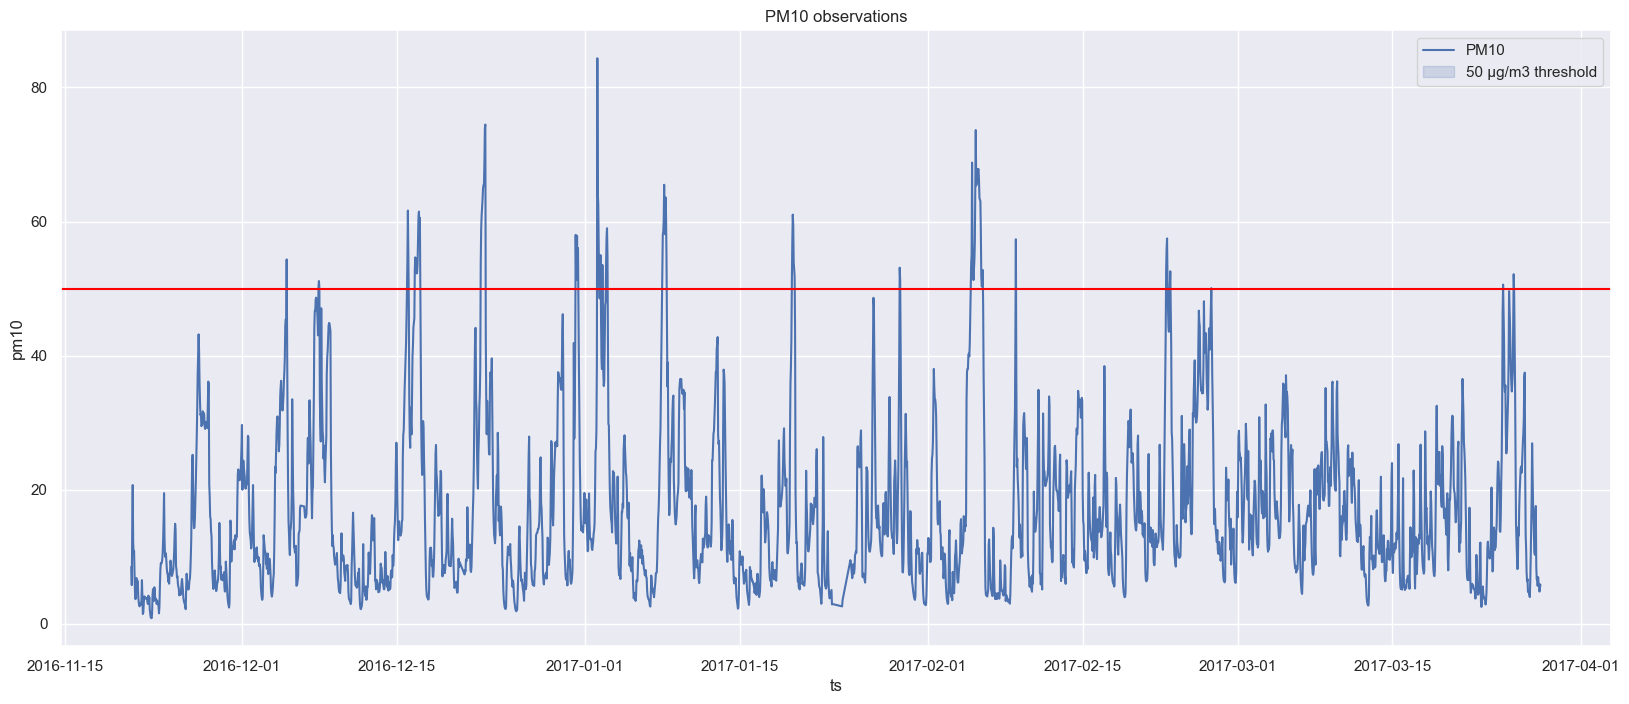

In [369]:
sns.set(rc={'figure.figsize':(20,8)})

graph = sns.lineplot(data=data['pm10'])
graph.axhline(y=50, color='red')
graph.set(title='PM10 observations')
graph.legend(labels=['PM10', '50 µg/m3 threshold'])

### PM2.5

In [111]:
data['pm25'].describe()

count    2998.000000
mean       15.826833
std        12.013201
min         0.733333
25%         7.190217
50%        12.103561
75%        21.038722
max        72.896774
Name: pm25, dtype: float64

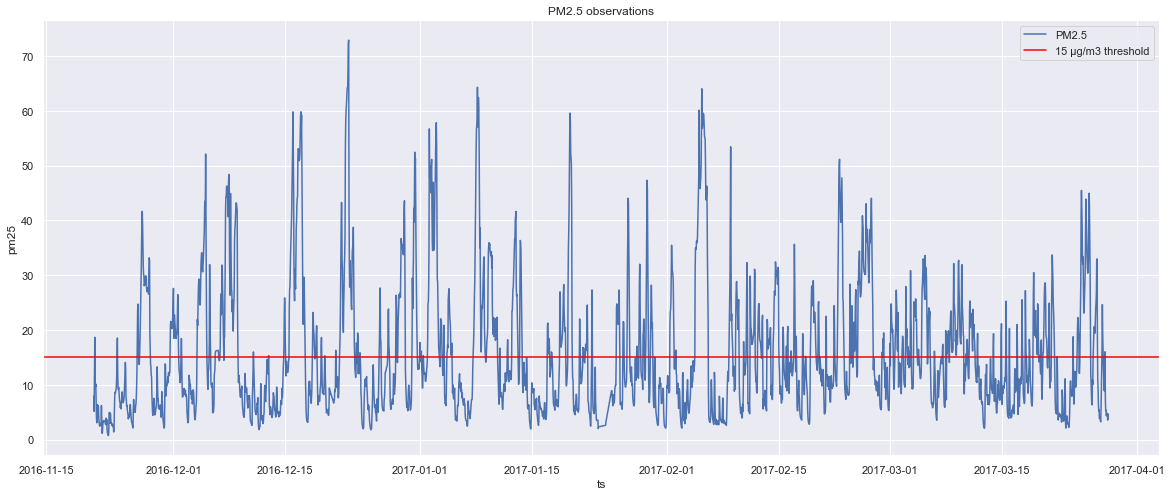

In [145]:
sns.set(rc={'figure.figsize':(20,8)})

graph = sns.lineplot(data=data['pm25'])
graph.axhline(y=15, color='red')
graph.set(title='PM2.5 observations')
graph.legend(labels=['PM2.5', '15 µg/m3 threshold'])

### Temperature

In [146]:
data['pm25'].describe()

count    2998.000000
mean       15.826833
std        12.013201
min         0.733333
25%         7.190217
50%        12.103561
75%        21.038722
max        72.896774
Name: pm25, dtype: float64

[Text(0.5, 1.0, 'Temperature observations')]

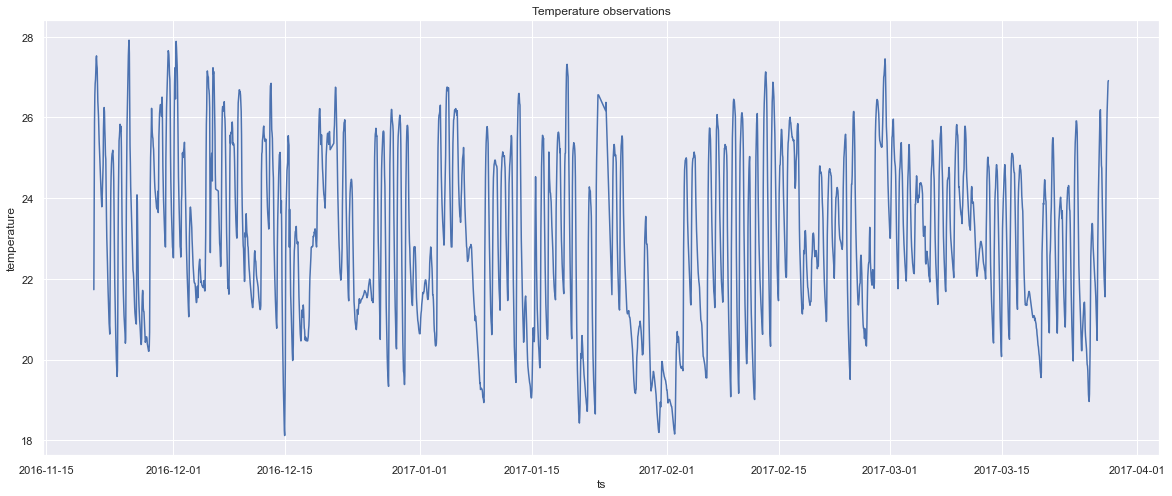

In [147]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot(data=data['temperature']).set(title='Temperature observations')

# Data prep

In [20]:
column_indices = {name: i for i, name in enumerate(data.columns)}
data_pm10 = data['temperature']
n = len(data_pm10)
train_df = data_pm10[0:int(n*0.7)]
test_df = data_pm10[int(n*0.7):]

In [21]:
train_df.values

array([21.73153846, 24.03288889, 25.8772    , ..., 21.48416667,
       21.43      , 21.38233333])

Prepare training and testing data for the LSTM model by creating windows of consecutive samples from the data.

In [17]:
def training_data(window):
    X_train = []
    Y_train = []
    for i in range(len(train_df)-window):
        tt = train_df.values[i:i+window]
        X_train.append([[t] for t in tt])
        Y_train.append(train_df.values[window+i])
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)

    return X_train, Y_train

def test_data(window):
    X_test = []
    Y_test = []
    for i in range(len(test_df)-window):
        tt = test_df.values[i:i+window]
        X_test.append([[t] for t in tt])
        Y_test.append(test_df.values[window+i])
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    return X_test, Y_test

In [18]:
X_test, Y_test = test_data(10)
X_train, Y_train = training_data(10)

In [19]:
train_univariate = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_univariate = train_univariate.cache().shuffle(10000).batch(256).repeat()

In [11]:
pd.DataFrame(X_test)

ValueError: Must pass 2-d input. shape=(895, 5, 1)

# LSTM Model

In [122]:
lstm_model = Sequential()
lstm_model.add(LSTM(16, return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [123]:
# Training
lstm_model.fit(X_train, Y_train, batch_size=1, epochs=10)

Epoch 1/10
2093/2093 [==============================] - 6s 2ms/step - loss: 84.9148
Epoch 2/10
2093/2093 [==============================] - 4s 2ms/step - loss: 3.1225
Epoch 3/10
2093/2093 [==============================] - 4s 2ms/step - loss: 0.8350
Epoch 4/10
2093/2093 [==============================] - 4s 2ms/step - loss: 0.4198
Epoch 5/10
2093/2093 [==============================] - 5s 2ms/step - loss: 0.2667
Epoch 6/10
2093/2093 [==============================] - 5s 3ms/step - loss: 0.2184
Epoch 7/10
2093/2093 [==============================] - 6s 3ms/step - loss: 0.1959
Epoch 8/10
2093/2093 [==============================] - 5s 2ms/step - loss: 0.1848
Epoch 9/10
2093/2093 [==============================] - 5s 3ms/step - loss: 0.1772
Epoch 10/10
2093/2093 [==============================] - 5s 3ms/step - loss: 0.1698


In [124]:
# Prediction
predictions = lstm_model.predict(X_test)
mean_absolute_percentage_error(Y_test, predictions)

28/28 [==============================] - 1s 2ms/step


0.008731387568393253

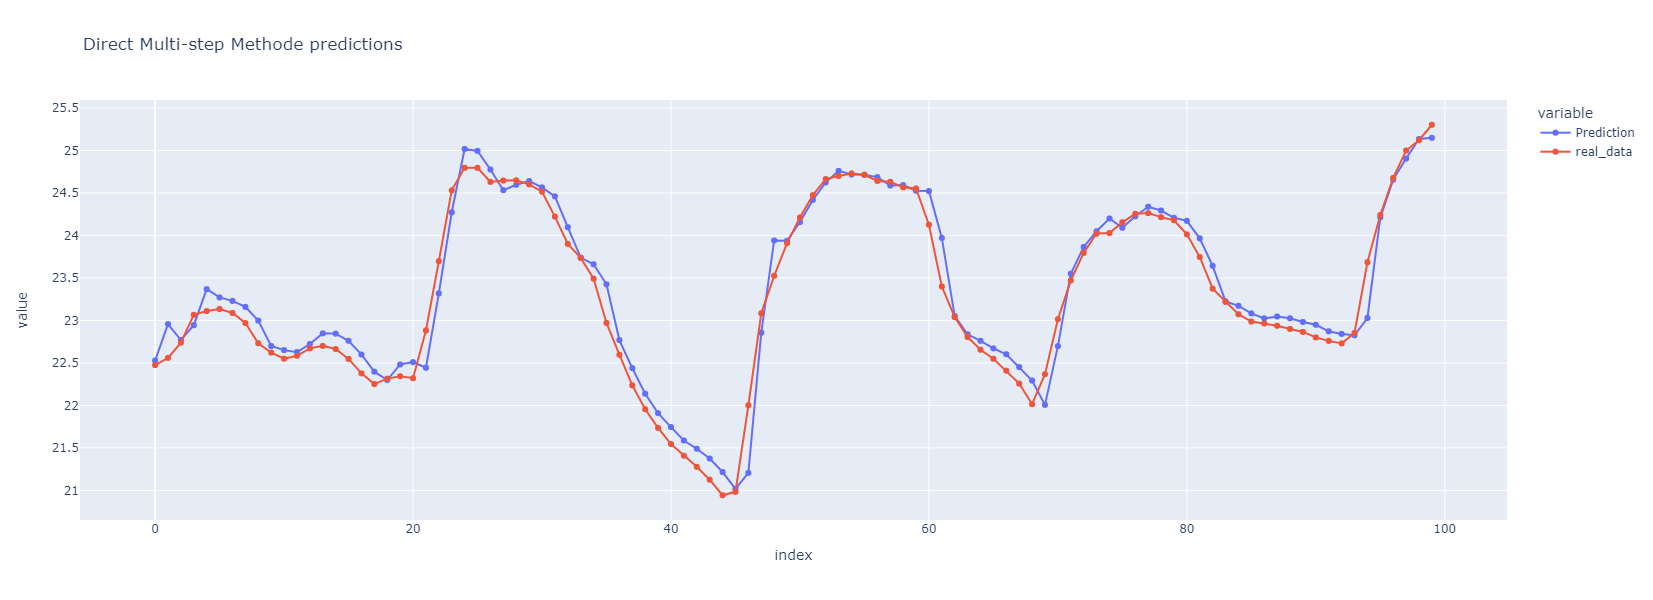

In [125]:
result_df = pd.DataFrame()
result_df['Prediction'] = predictions[:100].flatten()
result_df['real_data'] = Y_test[:100].flatten()

fig = px.line(result_df, title='Direct Multi-step Methode predictions', markers=True, width=1000, height=600)
fig.show()

This is one step forcasting so the results are accurate if we want to predict multiple steps we have to use different methodes.

## Multi-Step Time Series Forecasting
### Recursive methode

In [126]:
X_test_r, Y_test_r = test_data(15)
X_train_r, Y_train_r = training_data(15)

In [127]:
lstm_model = Sequential()
lstm_model.add(LSTM(16, return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [128]:
# Training
lstm_model.fit(X_train_r, Y_train_r, batch_size=1, epochs=10)

Epoch 1/10
2083/2083 [==============================] - 8s 3ms/step - loss: 94.6267
Epoch 2/10
2083/2083 [==============================] - 8s 4ms/step - loss: 3.5892
Epoch 3/10
2083/2083 [==============================] - 11s 5ms/step - loss: 1.0872
Epoch 4/10
2083/2083 [==============================] - 8s 4ms/step - loss: 0.4661
Epoch 5/10
2083/2083 [==============================] - 8s 4ms/step - loss: 0.3229
Epoch 6/10
2083/2083 [==============================] - 8s 4ms/step - loss: 0.2669
Epoch 7/10
2083/2083 [==============================] - 8s 4ms/step - loss: 0.2353
Epoch 8/10
2083/2083 [==============================] - 8s 4ms/step - loss: 0.2157
Epoch 9/10
2083/2083 [==============================] - 8s 4ms/step - loss: 0.2025
Epoch 10/10
2083/2083 [==============================] - 8s 4ms/step - loss: 0.1928


In [129]:
X_test_1 = X_test_r[:1]
predictions = []
for i in range(len(Y_test_r)):
    pred = lstm_model.predict(X_test_1)
    X_test_1 = np.append(X_test_1[0, 1:], pred, axis=0)
    X_test_1 = X_test_1.reshape(X_test_r[:1].shape)
    
    predictions.append(pred)

1/1 [==============================] - 0s 24ms/step


KeyboardInterrupt: 

In [130]:
mean_absolute_percentage_error(Y_test_r[:5].flatten(), np.array(predictions).flatten()[:5])

0.026787052451532456

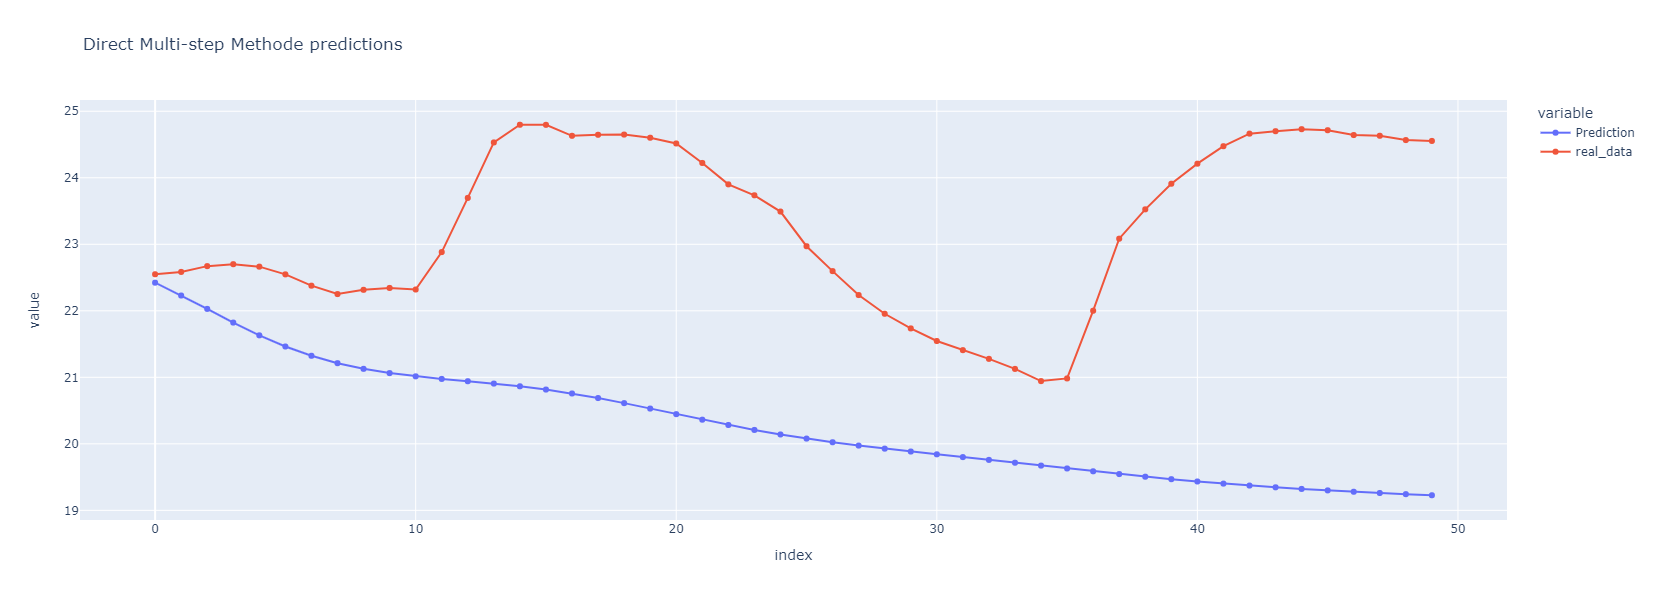

In [131]:
result_df = pd.DataFrame()
result_df['Prediction'] = np.array(predictions).flatten()[:50]
result_df['real_data'] = Y_test_r[:50].flatten()

fig = px.line(result_df, title='Direct Multi-step Methode predictions', markers=True, width=1000, height=600)
fig.show()

### Direct Multi-step Methode
With this methode we train a model for each step we want to predict.

In [132]:
def training_data_t2(window):
    X_train = []
    Y_train = []
    for i in range(len(train_df)-window-1):
        tt = train_df.values[i:i+window]
        X_train.append([[t] for t in tt])
        Y_train.append(train_df.values[window+i+1])
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)

    return X_train, Y_train

def test_data_t2(window):
    X_test = []
    Y_test = []
    for i in range(len(test_df)-window-1):
        tt = test_df.values[i:i+window]
        X_test.append([[t] for t in tt])
        Y_test.append(test_df.values[window+i+1])
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    return X_test, Y_test

In [133]:
X_test_t2, Y_test_t2 = test_data_t2(5)
X_train_t2, Y_train_t2 = training_data_t2(5)

In [134]:
lstm_model_t2 = Sequential()
lstm_model_t2.add(LSTM(16, return_sequences=False))
lstm_model_t2.add(Dense(1))
lstm_model_t2.compile(optimizer='adam', loss='mean_squared_error')

In [135]:
lstm_model_t2.fit(X_train_t2, Y_train_t2, batch_size=1, epochs=10)

Epoch 1/10
2092/2092 [==============================] - 6s 2ms/step - loss: 97.8021
Epoch 2/10
2092/2092 [==============================] - 4s 2ms/step - loss: 4.5111
Epoch 3/10
2092/2092 [==============================] - 4s 2ms/step - loss: 2.1005
Epoch 4/10
2092/2092 [==============================] - 4s 2ms/step - loss: 1.2206
Epoch 5/10
2092/2092 [==============================] - 5s 2ms/step - loss: 0.9616
Epoch 6/10
2092/2092 [==============================] - 5s 2ms/step - loss: 0.8289
Epoch 7/10
2092/2092 [==============================] - 5s 2ms/step - loss: 0.7371
Epoch 8/10
2092/2092 [==============================] - 6s 3ms/step - loss: 0.6769
Epoch 9/10
2092/2092 [==============================] - 5s 2ms/step - loss: 0.6448
Epoch 10/10
2092/2092 [==============================] - 5s 3ms/step - loss: 0.6163


In [136]:
# Prediction
predictions_t2 = lstm_model_t2.predict(X_test_t2)
mean_absolute_percentage_error(Y_test_t2, predictions_t2)

28/28 [==============================] - 1s 2ms/step


0.017020767874613017

In [137]:
result_df = pd.DataFrame()

In [138]:
result_df['Prediction'] = predictions_t2[:100].flatten()
result_df['real_data'] = Y_test_t2[:100].flatten()

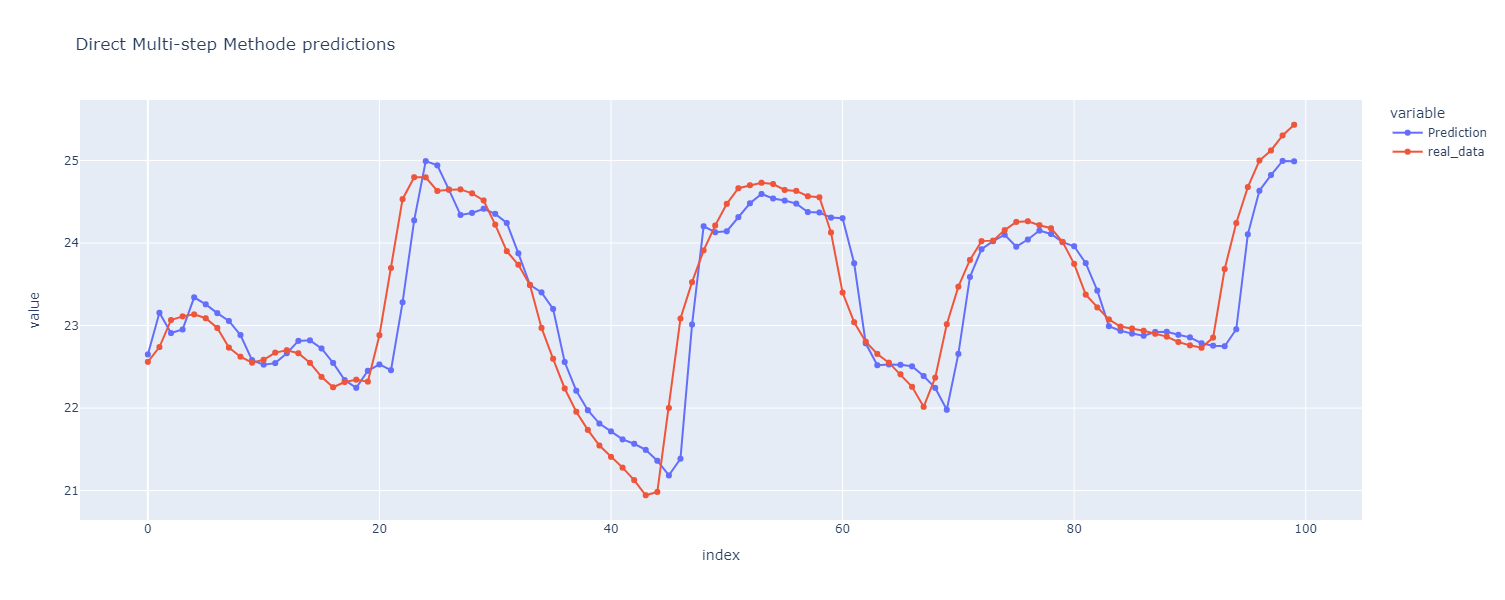

In [139]:

fig = px.line(result_df, title='Direct Multi-step Methode predictions', markers=True, width=1000, height=600)
fig.show()

### Multiple Output Methode

In [ ]:
def training_data_t3(window):
    X_train = []
    Y_train = []
    for i in range(len(train_df)-window-10):
        tt = train_df.values[i:i+window]
        X_train.append([[t] for t in tt])
        Y_train.append(train_df.values[window+i:window+i+10])
    X_train = np.array(X_train)
    Y_train = np.array(Y_train, dtype=object).astype(np.float32)

    return X_train, Y_train

def test_data_t3(window):
    X_test = []
    Y_test = []
    for i in range(len(test_df)-window-10):
        tt = test_df.values[i:i+window]
        X_test.append([[t] for t in tt])
        Y_test.append(test_df.values[window+i:window+i+10])
    X_test = np.array(X_test)
    Y_test = np.array(Y_test, dtype=object).astype(np.float32)

    return X_test, Y_test

In [ ]:
X_test_t3, Y_test_t3 = test_data_t3(10)
X_train_t3, Y_train_t3 = training_data_t3(10)

In [ ]:
lstm_model_t3 = Sequential()
lstm_model_t3.add(LSTM(16, return_sequences=False))
lstm_model_t3.add(Dense(10))
lstm_model_t3.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
lstm_model_t3.fit(X_train_t3, Y_train_t3, batch_size=1, epochs=10)

Epoch 1/10
2078/2078 [==============================] - 7s 2ms/step - loss: 130.2386
Epoch 2/10
2078/2078 [==============================] - 5s 2ms/step - loss: 4.8530
Epoch 3/10
2078/2078 [==============================] - 5s 3ms/step - loss: 3.5718
Epoch 4/10
2078/2078 [==============================] - 5s 2ms/step - loss: 3.1735
Epoch 5/10
2078/2078 [==============================] - 5s 2ms/step - loss: 2.9519
Epoch 6/10
2078/2078 [==============================] - 6s 3ms/step - loss: 2.7516
Epoch 7/10
2078/2078 [==============================] - 6s 3ms/step - loss: 2.6629
Epoch 8/10
2078/2078 [==============================] - 6s 3ms/step - loss: 2.5900
Epoch 9/10
2078/2078 [==============================] - 6s 3ms/step - loss: 2.5529
Epoch 10/10
2078/2078 [==============================] - 6s 3ms/step - loss: 2.4879


In [ ]:
# Prediction
predictions_t3 = lstm_model_t3.predict(X_test_t3)
mean_absolute_percentage_error(Y_test_t3, predictions_t3)

28/28 [==============================] - 1s 1ms/step


0.04074069

In [ ]:
lstm_model_t3.predict(X_test_t3)

28/28 [==============================] - 0s 2ms/step


array([[23.487394, 23.201849, 23.030693, ..., 23.131012, 23.059868,
        23.420774],
       [23.301365, 23.022322, 22.851873, ..., 23.072292, 23.026972,
        23.394354],
       [23.324793, 23.05516 , 22.888914, ..., 23.119778, 23.075075,
        23.430202],
       ...,
       [22.2269  , 22.022131, 21.901125, ..., 22.645742, 22.721884,
        23.09756 ],
       [22.0742  , 21.89898 , 21.803862, ..., 22.630526, 22.721443,
        23.087639],
       [21.911037, 21.755404, 21.678001, ..., 22.576994, 22.683243,
        23.047426]], dtype=float32)

In [ ]:
result_df = pd.DataFrame()

In [31]:
real_window

NameError: name 'real_window' is not defined

In [ ]:
k = 1

predictions_window = np.append(X_test_t3[k,:,0], predictions_t3[k])
real_window = np.append(X_test_t3[k,:,0], Y_test_t3[k])

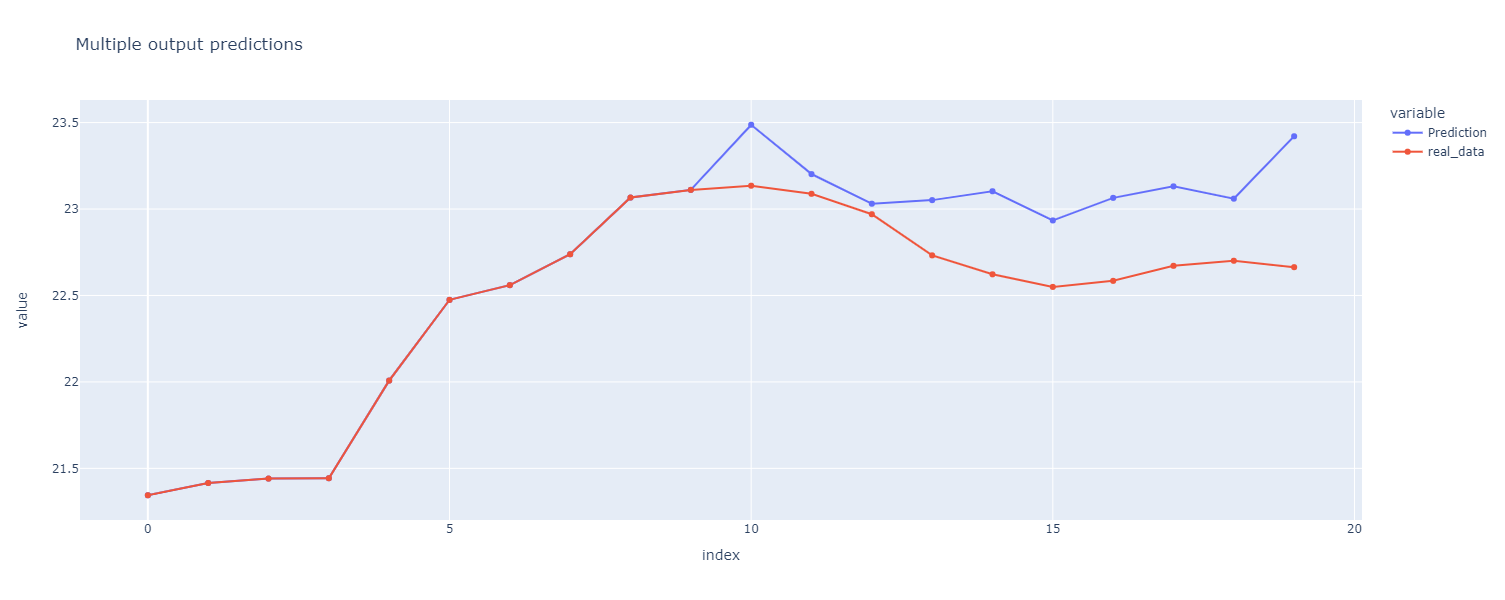

In [ ]:
result_df['Prediction'] = predictions_window
result_df['real_data'] = real_window
fig = px.line(result_df, title='Multiple output predictions', markers=True, width=1000, height=600)

fig.show()

In [133]:
data['t_change'] = data['temperature'].diff() / (data['temperature'].diff() - data['temperature'])

In [142]:
data['t_change'] = data['t']

,co2,humidity,pm10,pm25,temperature,voc,hour,t_change,month,weekday
ts,,,,,,,,,,
2016-11-21 00:00:00,693.846154,68.351538,8.515385,7.900000,21.731538,0.062000,0,NaN,11,0
2016-11-21 01:00:00,760.377778,61.866000,5.777778,5.151111,24.032889,0.062889,1,-0.105899,11,0
2016-11-21 02:00:00,1174.200000,59.996400,14.792000,12.840000,25.877200,0.063200,2,-0.076741,11,0
2016-11-21 03:00:00,1397.740741,59.742963,20.703704,18.666667,26.562963,0.066222,3,-0.026501,11,0
2016-11-21 04:00:00,1413.727273,58.885455,12.222727,11.272727,26.835909,0.062773,4,-0.010275,11,0
...,...,...,...,...,...,...,...,...,...,...
2017-03-28 05:00:00,870.133333,38.436333,6.075000,4.610000,26.108500,0.084283,5,-0.019996,3,1
2017-03-28 06:00:00,1038.140351,38.682807,5.854386,4.659649,26.379298,0.138474,6,-0.010372,3,1
2017-03-28 07:00:00,1203.316667,38.761000,4.816667,3.553333,26.668500,0.112400,7,-0.010963,3,1


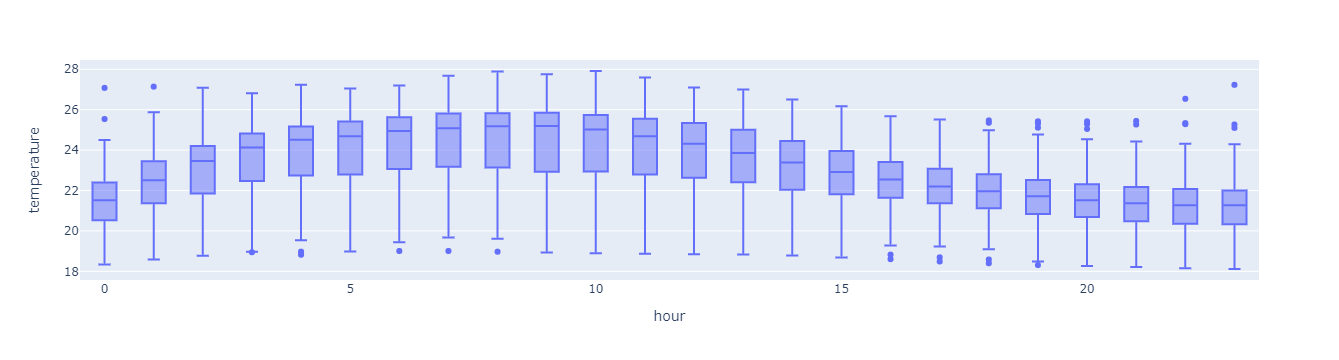

In [143]:
 px.box(data, x="hour", y="temperature")

### Variation Correction

In [141]:
correction = Sequential()
correction.add(LSTM(16, return_sequences=False))
correction.add(Dense(10))
correction.compile(optimizer='adam', loss='mean_squared_error')

# ARIMA Model

C:\Users\Hugo\anaconda3\envs\unsw\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


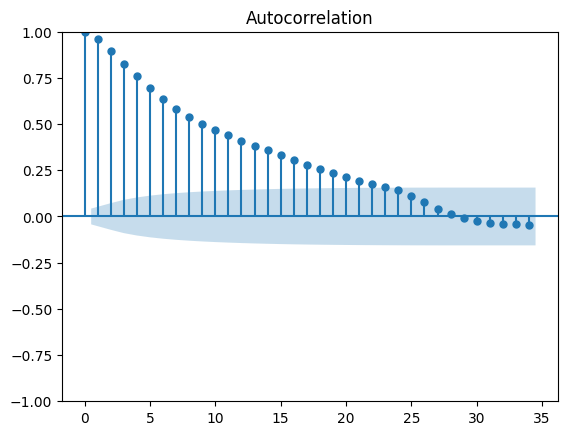

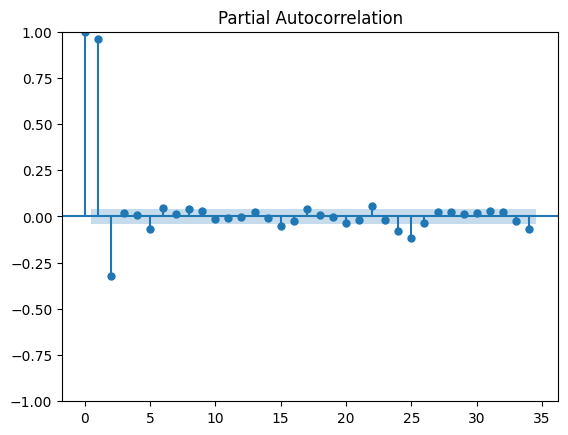

In [18]:
acf_original = plot_acf(train_df)
pacf_original = plot_pacf(train_df)

Time series data is not stationary

<AxesSubplot: xlabel='ts'>

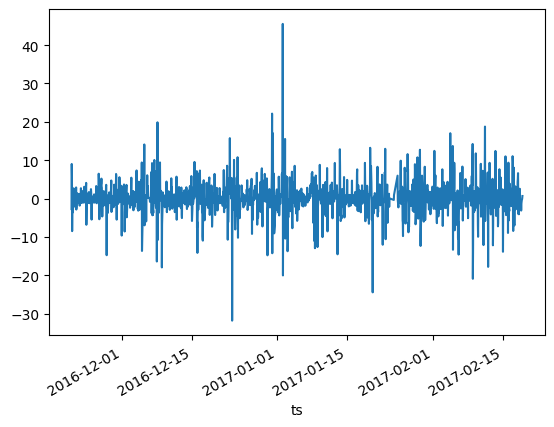

In [19]:
df_train_diff = train_df.diff().dropna()
df_train_diff.plot()

C:\Users\Hugo\anaconda3\envs\unsw\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


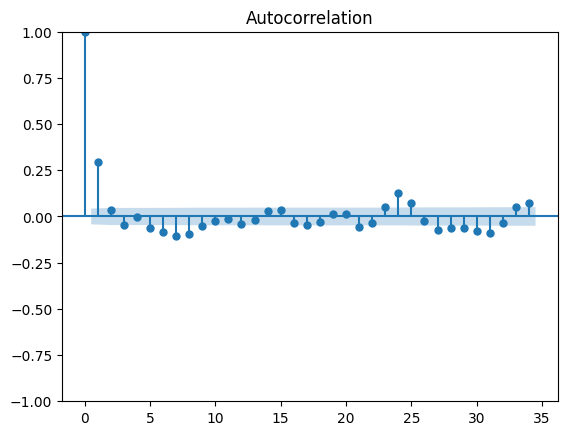

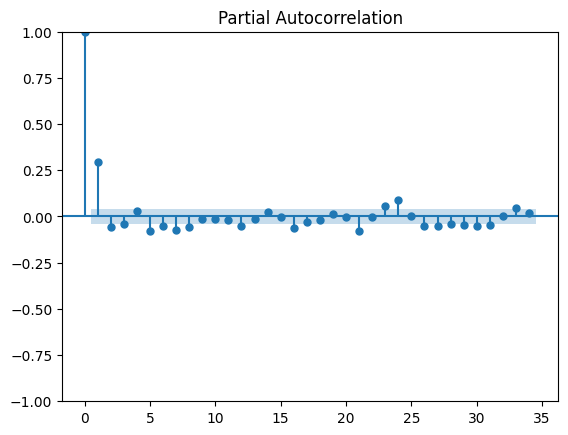

In [20]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

In [29]:
model = ARIMA(train_df, order=(2,1,0))
model_fit = model.fit()

C:\Users\Hugo\anaconda3\envs\unsw\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hugo\anaconda3\envs\unsw\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hugo\anaconda3\envs\unsw\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Hugo\anaconda3\envs\unsw\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot: xlabel='ts'>

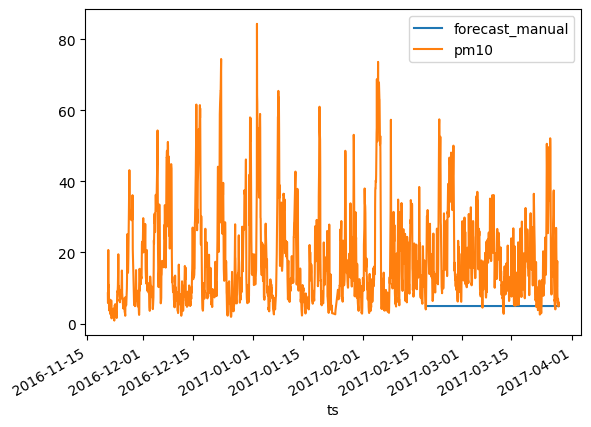

In [27]:

forecast_test = model_fit.forecast(len(test_df))

data['forecast_manual'] = [None]*len(train_df) + list(forecast_test)

data[['forecast_manual', 'pm10']].plot()

# Auto ML

**Notes:**
> Preprocessing the data doesn't give good results

> You can just input raw data and autokeras should do the preprocessing by itself provided you your data has been split and you have inputed the lookback period

**Results:**

| Params | value |
| ----------- | ----------- |
| predict_from | 1 |
|predict_until | 10 |
|lookback | 10 |
|batch_size | 1 |
|epochs | 5 |

loss: 150.5059 - mean_squared_error: 150.5059 - val_loss: 79.5516 - val_mean_squared_error: 79.5516

In [14]:
val_split = int(len(data) * 0.7)
train_df = data[:val_split]
val_df = data[val_split:]

In [18]:
data_x = train_df[['temperature']].astype("float64")

data_x_val = val_df[['temperature']].astype("float64")

# Data with train data and the unseen data from subsequent time steps.
data_x_test = data[['temperature']].astype("float64")

data_y = train_df["temperature"].astype("float64")

data_y_val = val_df["temperature"].astype("float64")

print(data_x.shape)  # (6549, 12)
print(data_y.shape)  # (6549,)

(2098, 1)
(2098,)


In [20]:
predict_from = 1
predict_until = 3
lookback = 5
clf = ak.TimeseriesForecaster(
    lookback=lookback,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=5,
    objective="val_loss",
)
# Train the TimeSeriesForecaster with train data
clf.fit(
    x=data_x,
    y=data_y,
    validation_data=(data_x_val, data_y_val),
    batch_size=2,
    epochs=5,
)
# Predict with the best model(includes original training data).
predictions = clf.predict(data_x_test)
print(clf.evaluate(data_x_val, data_y_val))

Trial 5 Complete [00h 02m 14s]
val_loss: 2.6619620323181152

Best val_loss So Far: 2.6619620323181152
Total elapsed time: 00h 07m 51s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/5
1045/1045 [==============================] - 35s 19ms/step - loss: 150.2682 - mean_squared_error: 150.2682 - val_loss: 10.3921 - val_mean_squared_error: 10.3921
Epoch 2/5
1045/1045 [==============================] - 23s 16ms/step - loss: 6.2731 - mean_squared_error: 6.2731 - val_loss: 2.7534 - val_mean_squared_error: 2.7534
Epoch 3/5
1045/1045 [==============================] - 24s 16ms/step - loss: 4.9312 - mean_squared_error: 4.9312 - val_loss: 2.6620 - val_mean_squared_error: 2.6620
Epoch 4/5
1045/1045 [==============================] - 31s 22ms/step - loss: 4.8651 - mean_squared_error: 4.8651 - val_loss: 2.6816 - val_mean_squared_error: 2.6816
Epoch 5/5
1045/1045 [==============================] - 30s 19ms/step - loss: 4.8720 - mean_squared_error: 4.8720 - val_loss: 2.7337 - val_mean_squared_error: 2.7337


INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


1497/1497 [==============================] - 11s 4ms/step


InvalidArgumentError: Graph execution error:

Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "C:\Users\Hugo\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Hugo\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Hugo\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Hugo\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Hugo\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Hugo\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Hugo\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\Hugo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Hugo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Hugo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Hugo\AppData\Local\Temp\ipykernel_7824\50449697.py", line 21, in <cell line: 21>
      print(clf.evaluate(data_x_val, data_y_val))
    File "C:\Users\Hugo\anaconda3\lib\site-packages\autokeras\tasks\time_series_forecaster.py", line 133, in evaluate
      return super().evaluate(x=x[: len(y)], y=y[self.lookback - 1 :], **kwargs)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\autokeras\tasks\structured_data.py", line 187, in evaluate
      return super().evaluate(x=x, y=y, **kwargs)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\autokeras\auto_model.py", line 492, in evaluate
      return utils.evaluate_with_adaptive_batch_size(
    File "C:\Users\Hugo\anaconda3\lib\site-packages\autokeras\utils\utils.py", line 68, in evaluate_with_adaptive_batch_size
      return run_with_adaptive_batch_size(
    File "C:\Users\Hugo\anaconda3\lib\site-packages\autokeras\utils\utils.py", line 101, in run_with_adaptive_batch_size
      history = func(x=x, validation_data=validation_data, **fit_kwargs)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\autokeras\utils\utils.py", line 70, in <lambda>
      lambda x, validation_data, **kwargs: model.evaluate(
    File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\engine\training.py", line 1667, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
Incompatible shapes: [32,1] vs. [2,1]
	 [[{{node mean_squared_error/SquaredDifference}}]] [Op:__inference_test_function_659965]

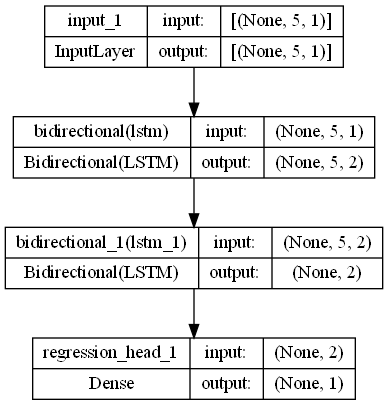

In [22]:
tf.keras.utils.plot_model(clf.export_model(), to_file = 'model_arch.png', show_shapes=True)

In [21]:
predictions

array([[23.431553],
       [23.431557],
       [23.431566]], dtype=float32)

In [177]:
model = clf.export_model()

try:
    model.save("model_autokeras", save_format="tf")
except Exception:
    model.save("model_autokeras.h5")

INFO:tensorflow:Assets written to: model_autokeras\assets


INFO:tensorflow:Assets written to: model_autokeras\assets


In [65]:
data_x.shape

(2098, 5)

In [3]:
from tensorflow.keras.models import load_model

loaded_model = load_model("model_autokeras")

predicted_y = loaded_model.predict(data_x_test)

NameError: name 'data_x_test' is not defined

In [179]:
prediction=[]
for i in predicted_y:
    prediction.append(i[0])

In [180]:
real=[]
for i in data_x_test.values:
    real.append(i[0])

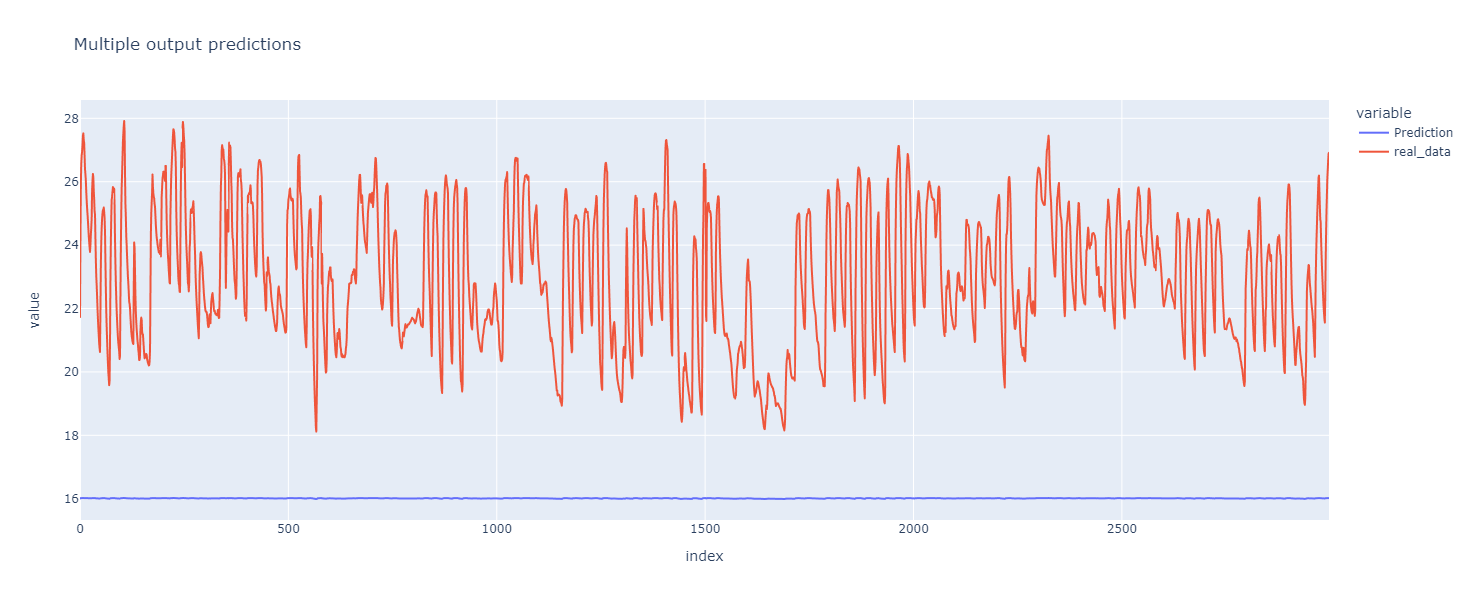

In [182]:
result_df = pd.DataFrame()
#predictions_window = np.append(X_test_t4[1], predicted_y[1])
#real_window = np.append(X_test_t4[1], Y_test_t4[1])
result_df['Prediction'] = prediction
result_df['real_data'] = real
fig = px.line(result_df, title='Multiple output predictions', width=1000, height=600)

fig.show()

# Results

To compare the models I chose to use the Mean Absolute Percentage Error (MAPE).  
It is the proportion of the average absolute difference between projected and true values divided by the true value. MAPE is simple to understand and is used to compare different forecast models which is why it's an interesting metric to use for our use case.

| Model | Experiment | TS window | Lookback Period | Result | Comment |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| LSTM | single step | 1h | 5 steps | 0.006697 | Good result but the model only predicts next value and probably learns to predict based on past momentum whichy makes it less accurate on momentum shifts |
| LSTM | recursive methode | 1h | ----------- | ----------- | Need more ime to work on it |
| LSTM | direct multi step | 1h | 5 steps | 0.01702 | Using n models to predict n steps ahead is more accurate but uses more resources |
| LSTM | multiple output | 1h | 10 steps | 0.0197 |  |
| ARIMA |  | 1h |  |  | Not going to use this |
| LSTM | auto ml | 1h |  |  | Hard to use, still testing |